#**KerasClassifier**

In [ ]:
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as k
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

In [4]:
df = pd.read_csv("advertising.csv")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


**Verificando se há dados nulos:**

In [5]:
df.isna().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

**Vamos dividir a coluna de tempo para Data e Hora:**

In [6]:
lista_tempo = []
lista_data = []
lista_hora = []
for i in range(0, len(df["Timestamp"])):
  lista_data.append(df["Timestamp"][i].split(",")[0].split(" ")[0])
  lista_hora.append(df["Timestamp"][i].split(",")[0].split(" ")[1])
df["Date"] = lista_data
df["Hour"] = lista_hora
df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Date,Hour
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,2016-03-27,00:53:11
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,2016-04-04,01:39:02
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,2016-03-13,20:35:42
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,2016-01-10,02:31:19
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,2016-06-03,03:36:18
...,...,...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1,2016-02-11,21:49:00
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1,2016-04-22,02:07:01
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1,2016-02-01,17:24:57
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0,2016-03-24,02:35:54


**Vamos transformar todas as colunas que contenham data em datetime:**

In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df["Hour"] = pd.to_datetime(df["Hour"])
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [8]:
df.dtypes

Daily Time Spent on Site           float64
Age                                  int64
Area Income                        float64
Daily Internet Usage               float64
Ad Topic Line                       object
City                                object
Male                                 int64
Country                             object
Timestamp                   datetime64[ns]
Clicked on Ad                        int64
Date                        datetime64[ns]
Hour                        datetime64[ns]
dtype: object

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [9]:
#"Male"
ohe =  OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[["Male"]])

df["Male"] = ohe.transform(df[["Male"]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 classes.**

In [10]:
# "Ad Topic Line", "City", "Country", "Timestamp"
oe =  OrdinalEncoder()
oe.fit(df[["Ad Topic Line", "City", "Country", "Timestamp", "Date", "Hour"]])

df[["Ad Topic Line", "City", "Country", "Timestamp", "Date", "Hour"]] = oe.transform(df[["Ad Topic Line", "City", "Country", "Timestamp", "Date", "Hour"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, transformar todas com média próximo de zero e desvio padrão próximo de 1**

In [11]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'Date', 'Hour'],
      dtype='object')

In [12]:
ssc = StandardScaler()

ssc.fit(df[['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country','Timestamp', "Date", "Hour"]])
h= ssc.transform(df[['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country','Timestamp', "Date", "Hour"]])
df[['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country','Timestamp', "Date", "Hour"]] = h

In [13]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Date,Hour
0,0.249267,-0.114905,0.509691,1.734030,-1.415086,1.700304,0.962695,1.424572,-0.209578,0,-0.214751,-1.588168
1,0.961132,-0.570425,1.002530,0.313805,-0.122976,1.492546,-1.038750,0.451875,-0.088335,0,-0.110587,-1.515117
2,0.282083,-1.139826,0.356949,1.287589,0.230363,-1.344415,0.962695,0.981136,-0.458994,0,-0.457800,1.194735
3,0.577432,-0.798185,-0.014456,1.501580,1.397766,1.621499,-1.038750,-0.177517,-1.536330,0,-1.551521,-1.417716
4,0.212664,-0.114905,1.408868,1.038731,0.923184,1.141508,0.962695,-0.277648,0.926648,0,0.913691,-1.264656


**Dividindo os dados em target e features e aplicando a divisão de dados de treino e dados de teste.**

**Construino a rede...**

In [14]:
X = df.drop(columns=["Clicked on Ad"])
y = df["Clicked on Ad"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=6, activation = "relu", kernel_initializer = "random_uniform", input_dim=11), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
               #2ª camada oculta
               tf.keras.layers.Dense(units=6, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2), #Dropout = % de colunas zeradas para não dar overfitting! Recomendável entre 0.2 e 0.3
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'sigmoid')])
    

    rn.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ['binary_accuracy'])


    return rn

In [ ]:
rn = KerasClassifier(model=criarRede)
#============================================================================================
optimizers = ['adam']
init = ['uniform']
epochs = [1000]
batches = [20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, model__init=init)

#================================================================================
grid_search = GridSearchCV(estimator=rn,
                           param_grid=param_grid,
                           scoring="accuracy",
                           cv=10)

grid_search = grid_search.fit(X_train, y_train)

**Salvar o modelo:**

In [16]:
import pickle

In [17]:
with open("grid_search.pkl", "wb") as f:
    pickle.dump(grid_search, f)

In [18]:
with open("grid_search.pkl", "rb") as f:
    
    grid_search = pickle.load(f)

In [19]:
grid_search.best_params_

{'batch_size': 20,
 'epochs': 1000,
 'model__init': 'uniform',
 'optimizer': 'adam'}

**Score:**

In [20]:
print(f"O melhor score foi de {(grid_search.best_score_)*100:.2f}%")

O melhor score foi de 95.57%


Superamos o XGBoost e Otimização Bayesiana


Métricas de avaliação de treino:
35/35 [==============================] - 0s 3ms/step
[[345   5]
 [  6 344]]


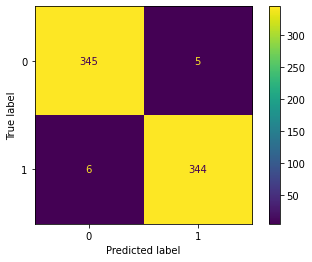

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       350
           1       0.99      0.98      0.98       350

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700


Métricas de avaliação de teste:
15/15 [==============================] - 0s 2ms/step
[[148   2]
 [  5 145]]


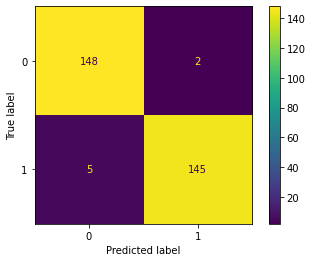

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       0.99      0.97      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [21]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_search.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_search.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

In [22]:
tabela = pd.DataFrame()
tabela["y real"] = y_test
tabela["y preditivo"] = y_pred_test
tabela

,y real,y preditivo
451,1,1
54,1,1
507,1,1
467,1,1
285,0,0
...,...,...
527,0,0
204,0,0
9,0,0
127,0,0


Salvando a tabela...

In [23]:
tabela.to_csv("tabela_comparação.csv")

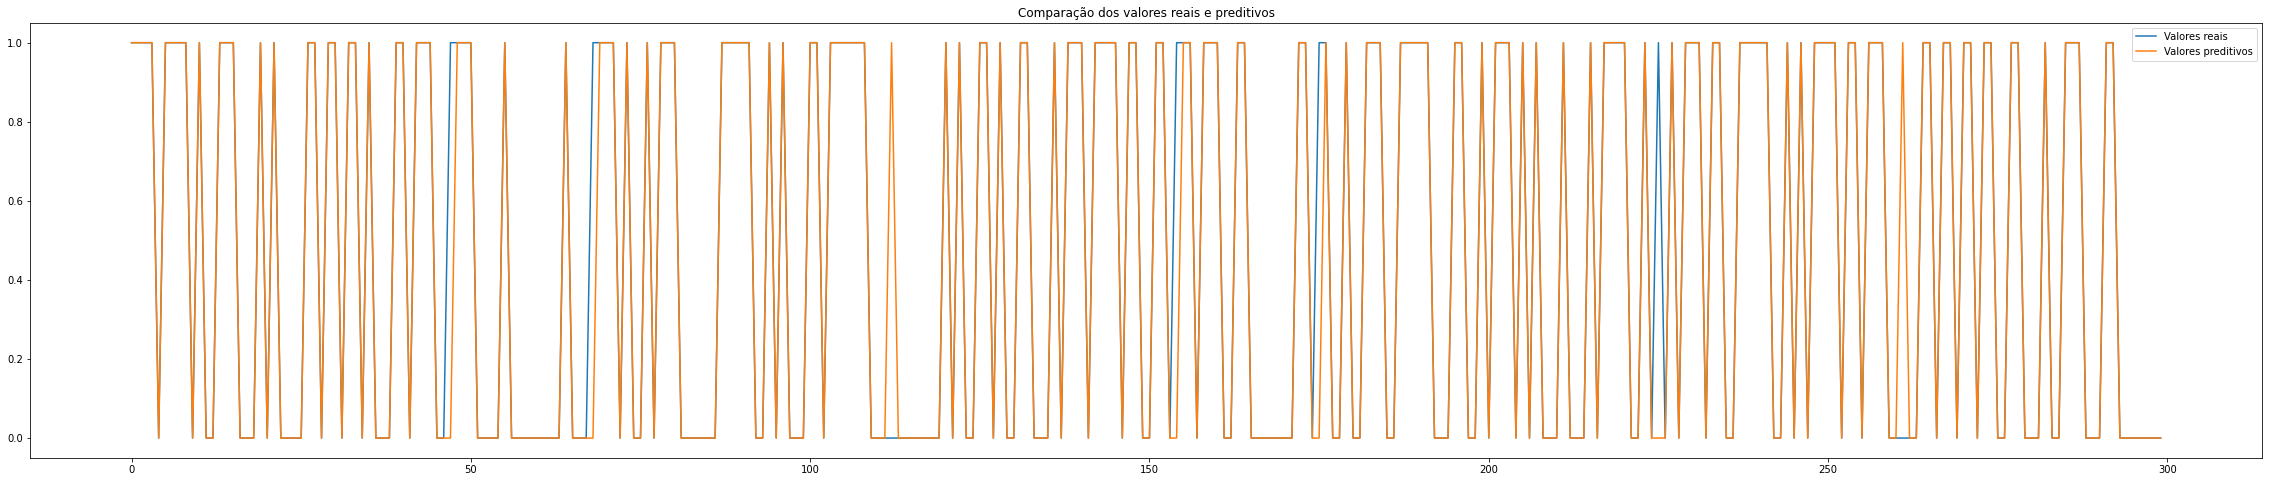

In [24]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred_test, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();